Training model with dropout_rate=0.2, lstm_units=50


c:\Users\DELL\anaconda3\envs\solar_prediction\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
8241/8241 ━━━━━━━━━━━━━━━━━━━━ 214s 26ms/step - loss: 0.0174 - val_loss: 0.0215
Epoch 2/50
8241/8241 ━━━━━━━━━━━━━━━━━━━━ 242s 29ms/step - loss: 0.0143 - val_loss: 0.0215
Epoch 3/50
8241/8241 ━━━━━━━━━━━━━━━━━━━━ 239s 29ms/step - loss: 0.0138 - val_loss: 0.0209
Epoch 4/50
8241/8241 ━━━━━━━━━━━━━━━━━━━━ 235s 29ms/step - loss: 0.0133 - val_loss: 0.0212
Epoch 5/50
8241/8241 ━━━━━━━━━━━━━━━━━━━━ 223s 27ms/step - loss: 0.0128 - val_loss: 0.0222
Epoch 6/50
8241/8241 ━━━━━━━━━━━━━━━━━━━━ 235s 29ms/step - loss: 0.0123 - val_loss: 0.0225
Epoch 7/50
8241/8241 ━━━━━━━━━━━━━━━━━━━━ 237s 29ms/step - loss: 0.0116 - val_loss: 0.0230
Epoch 8/50
8241/8241 ━━━━━━━━━━━━━━━━━━━━ 246s 30ms/step - loss: 0.0110 - val_loss: 0.0243
Epoch 9/50
8241/8241 ━━━━━━━━━━━━━━━━━━━━ 243s 30ms/step - loss: 0.0105 - val_loss: 0.0250
Epoch 10/50
8241/8241 ━━━━━━━━━━━━━━━━━━━━ 248s 30ms/step - loss: 0.0099 - val_loss: 0.0248
Epoch 11/50
8241/8241 ━━━━━━━━━━━━━━━━━━━━ 251s 30ms/step - loss: 0.0094 - val_loss: 0.02

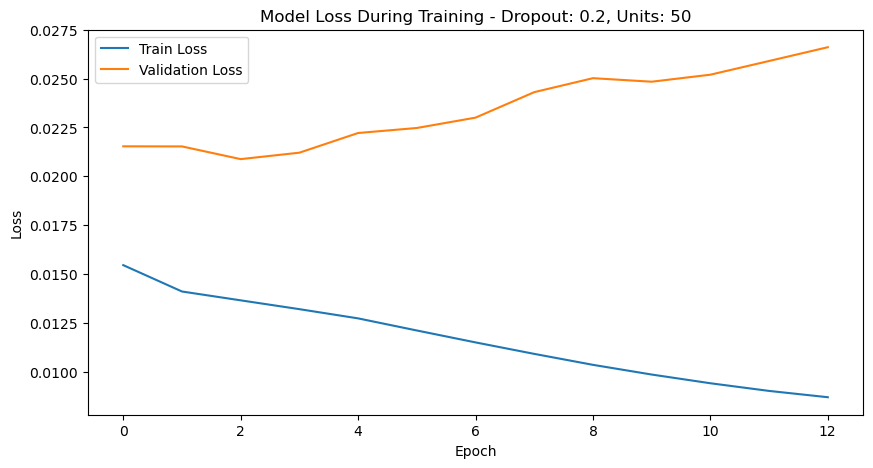

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import joblib

# Load the data
file_path = r"D:\Group Project\Train 12.00AM 3-10.5.xlsx"
data = pd.read_excel(file_path, parse_dates=['Time'])

# Initialize separate scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# List of feature and target columns
features_to_scale = ['Irradiation', 'Temp', 'Wind', 'Humidity', 'Barometer']
output_column = 'TOAL ACTIVE POWER [MW]'

# Apply feature scaler to the feature columns
data[features_to_scale] = feature_scaler.fit_transform(data[features_to_scale])

# Apply target scaler to the target column
data[[output_column]] = target_scaler.fit_transform(data[[output_column]])

# Save the scalers
joblib.dump(feature_scaler, 'feature_scalerNew1hr.pkl')
joblib.dump(target_scaler, 'target_scalerNew1hr.pkl')

# Prepare input and output data for the LSTM
sequence_length = 60  # Past time steps used as input
prediction_length = 60  # Future steps to predict

def create_sequences(input_data, target_data, sequence_length, prediction_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length - prediction_length + 1):
        X.append(input_data.iloc[i:i+sequence_length][features_to_scale].values)
        y.append(target_data.iloc[i:i+prediction_length][output_column].values)
    return np.array(X), np.array(y)

X, y = create_sequences(data, data, sequence_length, prediction_length)

# Define and compile the LSTM model
def build_model(dropout_rate=0.2, lstm_units=50):
    model = Sequential([
        Bidirectional(LSTM(lstm_units, activation='tanh', return_sequences=True), input_shape=(sequence_length, len(features_to_scale))),
        Dropout(dropout_rate),
        LSTM(lstm_units, activation='tanh'),
        Dense(prediction_length)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Early stopping to prevent overfitting
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model for the specific hyperparameters
dropout_rate = 0.2
lstm_units = 50
print(f"Training model with dropout_rate={dropout_rate}, lstm_units={lstm_units}")
model = build_model(dropout_rate, lstm_units)
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_monitor], verbose=1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss During Training - Dropout: {dropout_rate}, Units: {lstm_units}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Save the trained model
model.save('optimized_lstm_modeldeNew1hr.h5')


3462/3462 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step
Mean Squared Error (MSE) on Test Data: 1.7467191473790358
Root Mean Squared Error (RMSE) on Test Data: 1.321635028053901
Mean Absolute Error (MAE) on Test Data: 0.6437585335421365
R-squared (R2) on Test Data: 0.8028010693256644


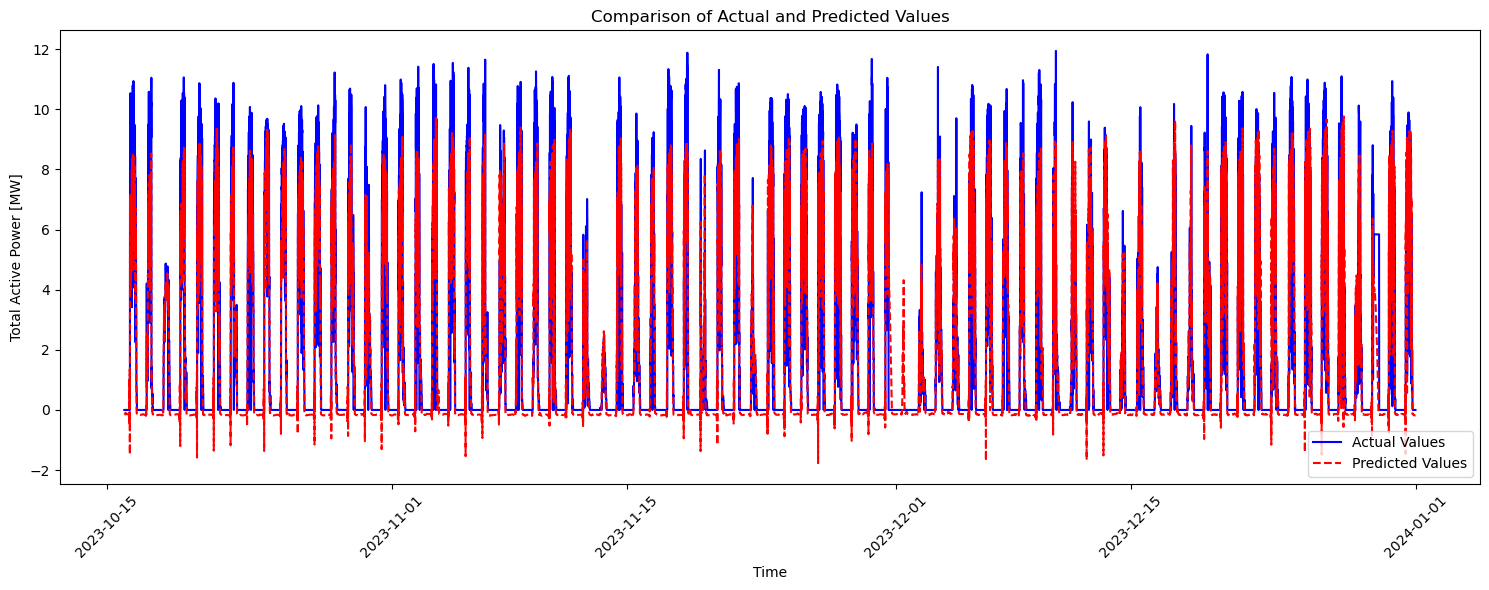

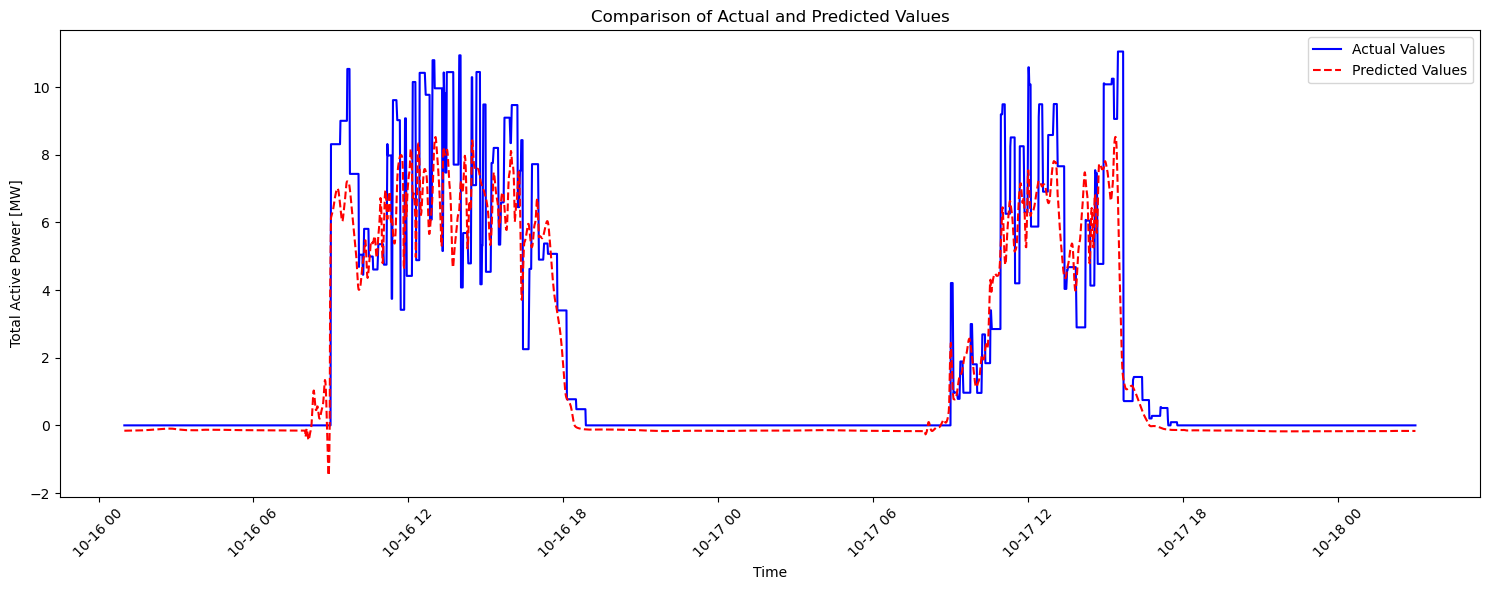

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the test data
test_file_path = r"D:\Group Project\Test 12.00AM 3-10.5.xlsx"
test_data = pd.read_excel(test_file_path, parse_dates=['Time'])

# Load the saved scalers
feature_scaler = joblib.load('feature_scalerNew1hr.pkl')
target_scaler = joblib.load('target_scalerNew1hr.pkl')

# List of feature and target columns
features_to_scale = ['Irradiation', 'Temp', 'Wind', 'Humidity', 'Barometer']
output_column = 'TOAL ACTIVE POWER [MW]'

# Apply the feature scaler to the test data
test_data[features_to_scale] = feature_scaler.transform(test_data[features_to_scale])

# Apply the target scaler to the target column
test_data[[output_column]] = target_scaler.transform(test_data[[output_column]])

# Generate sequences from the test data
def create_sequences(input_data, target_data, sequence_length, prediction_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length - prediction_length + 1):
        X.append(input_data[i:i+sequence_length][features_to_scale].values)
        y.append(target_data[i:i+prediction_length][output_column].values)
    return np.array(X), np.array(y)

sequence_length = 60  # Past time steps used as input
prediction_length = 60  # Future steps to predict

X_test, y_test = create_sequences(test_data, test_data, sequence_length, prediction_length)

# Load the trained model
model = load_model('optimized_lstm_modeldeNew1hr.h5')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actuals to compare them in their original scale
predictions_inverse = target_scaler.inverse_transform(predictions)
y_test_inverse = target_scaler.inverse_transform(y_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test_inverse, predictions_inverse)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inverse, predictions_inverse)
r2 = r2_score(y_test_inverse, predictions_inverse)

# Print the performance metrics
print(f"Mean Squared Error (MSE) on Test Data: {mse}")
print(f"Root Mean Squared Error (RMSE) on Test Data: {rmse}")
print(f"Mean Absolute Error (MAE) on Test Data: {mae}")
print(f"R-squared (R2) on Test Data: {r2}")

# Extract the timestamps corresponding to the starting points of the predictions
timestamps = test_data['Time'][sequence_length:-prediction_length+1].reset_index(drop=True)

# Optionally, plot the first few predicted vs actual values with time on the x-axis
plt.figure(figsize=(15, 6))
plt.plot(timestamps, y_test_inverse[:, 0], label='Actual Values',linestyle='-', color='blue')  # Adjust index if needed
plt.plot(timestamps, predictions_inverse[:, 0], label='Predicted Values',linestyle='--', color='red')  # Adjust index if needed
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Total Active Power [MW]')
plt.xticks(rotation=45)  # Rotate the timestamps for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()


# Number of points to display
num_points = 3000

# Optionally, plot the first few predicted vs actual values with time on the x-axis
plt.figure(figsize=(15, 6))
plt.plot(timestamps[:num_points], y_test_inverse[:num_points, 0], label='Actual Values', linestyle='-', color='blue')  # Adjust index if needed
plt.plot(timestamps[:num_points], predictions_inverse[:num_points, 0], label='Predicted Values', linestyle='--', color='red')  # Adjust index if needed
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Total Active Power [MW]')
plt.xticks(rotation=45)  # Rotate the timestamps for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()